In [76]:
import numpy as np
import pandas as pd

In [77]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


In [188]:
container = np.load("chess.npz")
ds = container["dataset"]
print(ds.shape)

(4554, 7)


## trying to use tensorflow

In [163]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [164]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.7.0


In [165]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [166]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [167]:
mydataset = pd.DataFrame(ds, columns=['h1','h2','h3','h4','h5','h6','H'])
mydataset.tail()

,h1,h2,h3,h4,h5,h6,H
3598,4.80,0.0,0.0,56473.2,-57030.3,-75.6,1164.36
3599,5.04,0.0,0.0,-56473.2,57030.3,102.0,-790.26
3600,7.32,0.0,0.0,56473.2,-56778.3,-69.6,1229.64
3601,6.84,0.0,40.0,-56473.2,56778.3,87.6,-509.46
3602,1.92,0.0,0.0,56473.2,-56526.3,-46.8,82161.46


In [168]:
mydataset.isna().sum()

h1    0
h2    0
h3    0
h4    0
h5    0
h6    0
H     0
dtype: int64

In [169]:
# Split the data into training and test sets
# Now, split the dataset into a training set and a test set. You will use the test set in the final evaluation of your models.
train_mydataset = mydataset.sample(frac=0.8, random_state=0)
test_mydataset = mydataset.drop(train_mydataset.index)

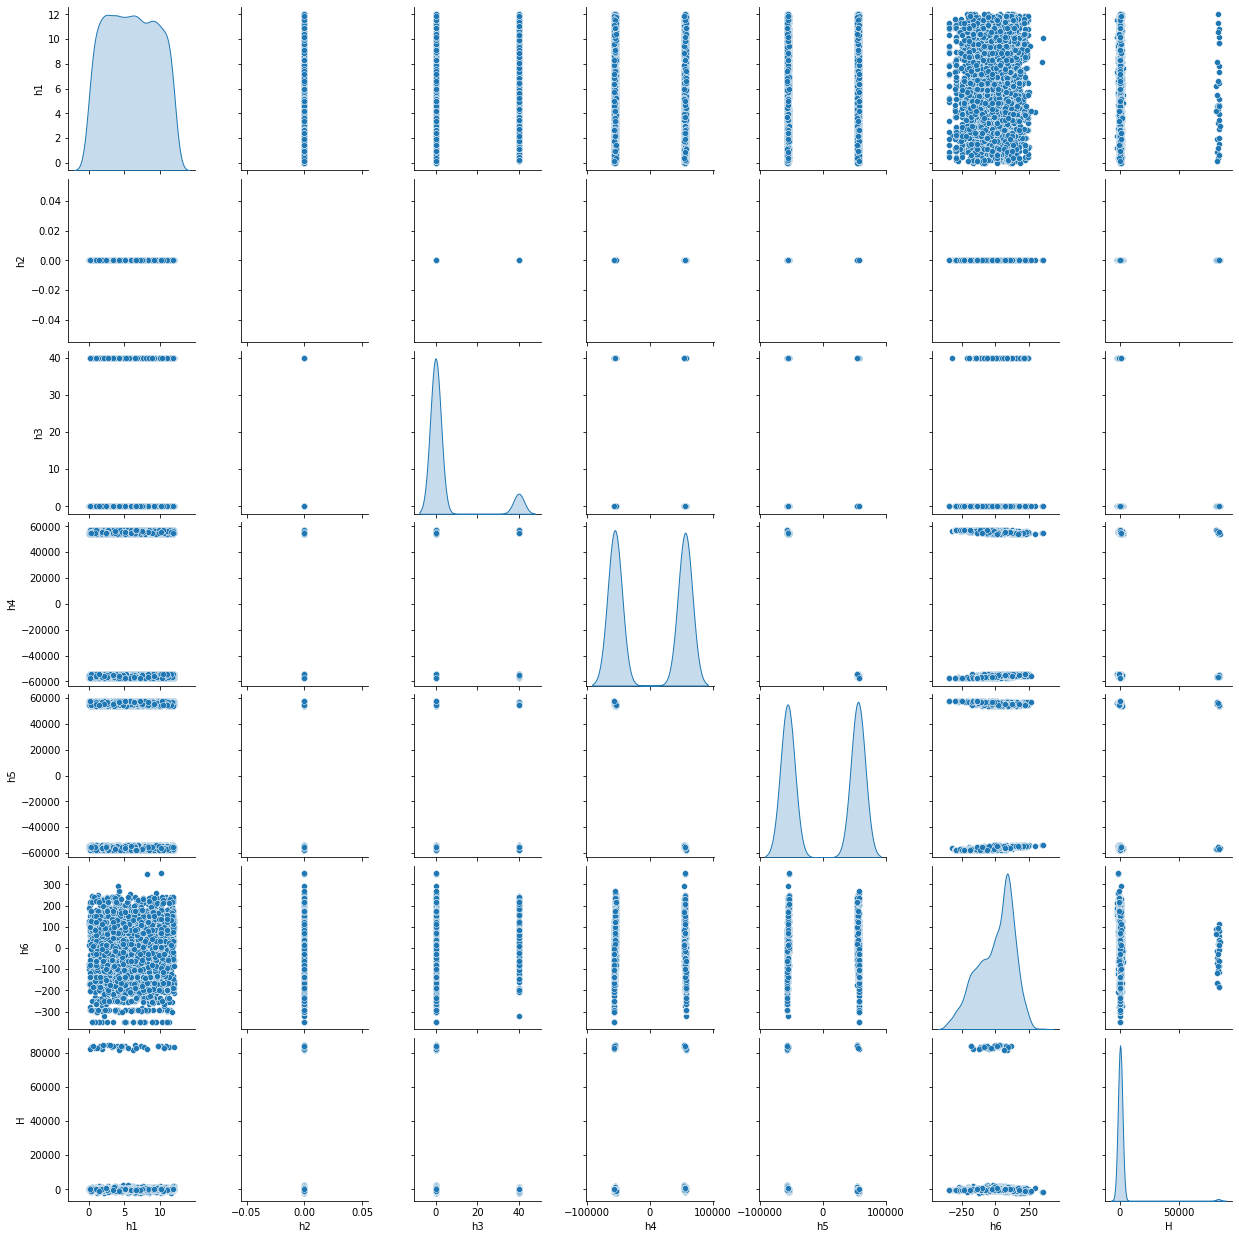

In [170]:
# Inspect the data
# Review the joint distribution of a few pairs of columns from the training set.
sns.pairplot(train_mydataset[['h1','h2','h3','h4','h5','h6','H']], diag_kind='kde')

In [171]:
# Let's also check the overall statistics. Note how each feature covers a very different range
train_mydataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
h1,2882.0,5.981013,3.428788,0.0,3.000,6.00,8.880,12.00
h2,2882.0,0.000000,0.000000,0.0,0.000,0.00,0.000,0.00
h3,2882.0,4.594032,12.755885,0.0,0.000,0.00,0.000,40.00
h4,2882.0,-459.086815,55789.373517,-57498.3,-55735.200,-54000.00,55735.200,57498.30
h5,2882.0,477.490597,55874.874257,-57498.3,-55717.200,54090.00,55717.200,57498.30
h6,2882.0,3.839001,132.721221,-346.8,-96.600,31.20,102.000,352.80
H,2882.0,1130.282172,9116.705294,-2300.4,-163.835,97.68,397.845,84428.56


In [172]:
# Split features from labels
# Separate the target value—the "label"—from the features. This label is the value that you will train the model to predict.
train_features = train_mydataset.copy()
test_features = test_mydataset.copy()

train_labels = train_features.pop('H')
test_labels = test_features.pop('H')

In [173]:
# Normalization
# In the table of statistics it's easy to see how different the ranges of each feature are
train_mydataset.describe().transpose()[['mean', 'std']]

,mean,std
h1,5.981013,3.428788
h2,0.000000,0.000000
h3,4.594032,12.755885
h4,-459.086815,55789.373517
h5,477.490597,55874.874257
h6,3.839001,132.721221
H,1130.282172,9116.705294


In [174]:
# It is good practice to normalize features that use different scales and ranges.
# The Normalization layer
# The tf.keras.layers.Normalization is a clean and simple way to add feature normalization into your model.

# The first step is to create the layer:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [175]:
# Then, fit the state of the preprocessing layer to the data by calling Normalization.adapt:
normalizer.adapt(np.array(train_features))

In [176]:
# Calculate the mean and variance, and store them in the layer:

print(normalizer.mean.numpy())

[[   5.981    0.       4.594 -459.087  477.491    3.839]]


In [177]:
# When the layer is called, it returns the input data, with each feature independently normalized:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
    print('First example:', first)
    print()
    print('Normalized:', normalizer(first).numpy())

First example: [[     3.24      0.        0.   -54270.    54773.1     138.  ]]

Normalized: [[-0.8   0.   -0.36 -0.96  0.97  1.01]]


In [178]:
def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error',
                  optimizer=tf.keras.optimizers.Adam(0.001))
    return model

In [179]:
#Regression using a DNN and multiple inputs
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_5 (Normalizat  (None, 6)                13        
 ion)                                                            
                                                                 
 dense_24 (Dense)            (None, 64)                448       
                                                                 
 dense_25 (Dense)            (None, 64)                4160      
                                                                 
 dense_26 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,686
Trainable params: 4,673
Non-trainable params: 13
_________________________________________________________________


In [180]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    epochs=100,
    verbose=0,
    validation_split=0.2)

Wall time: 11 s


In [181]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 2500])
    plt.xlabel('Epoch')
    plt.ylabel('Error [H]')
    plt.legend()
    plt.grid(True)

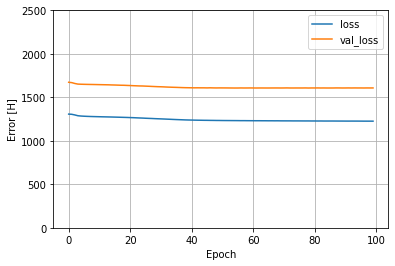

In [182]:
plot_loss(history)

In [183]:
test_results = {}

In [184]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [185]:
pd.DataFrame(test_results, index=['Mean absolute error [H]']).T

,Mean absolute error [H]
dnn_model,1347.987427


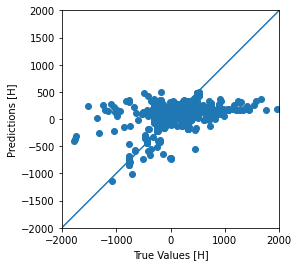

In [186]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [H]')
plt.ylabel('Predictions [H]')
lims = [-2000, 2000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

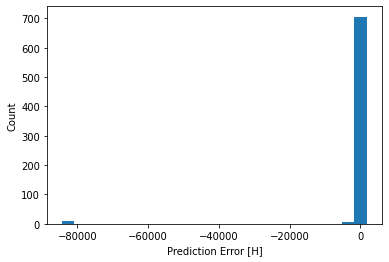

In [187]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [H]')
_ = plt.ylabel('Count')